## Тестовое задание: распределенные методы обучения
### Дарья Дятлова, студентка 5 курса ВШЭ

In [80]:
from typing import NoReturn, List
import numpy as np
import scipy.linalg
from numpy.linalg import det, norm, inv
import multiprocessing
import concurrent.futures
from itertools import repeat
from functools import partial
import matplotlib.pyplot as plt
import time

In [63]:
def print_matrix(A: np.ndarray) -> NoReturn:
    for row in A.astype(int):
        for x in row:
            print(f"{x:<4d}", end=" ")
        print()

def make_matrix(n):
  A = np.eye(n)
  b = np.random.rand(n)
  return A, b

## Задание 1
Дана матрица $A \in R^{n x n}$ и вектор $b \in R^n$. Известно, что матрица $A$ имеет диагональное преобладание. Найти такие $B \in R^{nxn}$ и $q \in R^n$, что последовательность
$x_{k+1} = Bx_k + q$ сходится к единственному решение системы $Ax^* = b$


---



Решение с помощью метода Якоби с условием строгого диагонального преобладания:

> Представим матрицу $A = B + D$, где $D$ – диагональная матрица.

> Тогда решение системы $Ax = b$ можно записать в следующем виде: $Dx + Bx = b$, откуда $x = D^{-1}b - D^{-1}Bx$.


> Решим систему с помощью итерационного метода: $x^{k+1} = Bx_k + q$, где $q = D^{-1}b$.


> Критерий остановки: $\frac{||b - Ax_i||}{||b||} \leq tol$



















In [ ]:
def jacobi(A: np.ndarray, b: np.ndarray, max_iter=1000, tol=1e-8) -> np.ndarray:

    """
    Parametrs
    ---------
    A: np.ndarray
        Матрица решаемой СЛАУ
    b: np.ndarray
        Вектор свободных членов СЛАУ
    max_iter: int
        Максимальное число итераций метода
    tol: Точность решения
    return: np.ndarray
        x: приближенное решение СЛАУ Ax = b
    """

    D = np.diag(np.diagonal(A))
    B = A - D
    assert [np.diagonal(A)[i] >= np.sum(B[i]) for i in range(len(b))],(
         'Matrix A is not diagonally dominant')
    x0 = np.random.rand(A.shape[0])
    x = np.array(x0, dtype=np.float128)
    D_inv = np.diag(1 / np.diagonal(A))
    b_norm = norm(b)
    q = D_inv @ b
    for i in range(max_iter):
      if norm(b - A @ x) / b_norm <= tol:
        return x
      else:
        x = B @ x + q

Напишем функцию для проверки корректности решения реализованной нами функцией со встроенной функцией для решения СЛАУ библиотеки Scipy:

In [ ]:
A = np.eye(20)
b = np.random.rand(20)
def test1(A: np.ndarray, b: np.ndarray):
  if np.isclose(scipy.linalg.solve(A, b), jacobi(A, b), rtol=1e-8).all():
    print('Correct!')
  else:
    print('Something went wrong')
test1(A,b)

Correct!


# Задание 2
Дана последовательность $x_{k+1} = Bx_k$:


*   При каких условиях $x_k$ сходится? 
*   Приведите пример $B$, когда все компоненты $x_k$ одинаковы.
---

*   Для сходимости $x_k$ достаточно, чтобы: $||B|| \leq 1$
*   Матрица $B$ у которой все $b_{ii}, i=1...N$ равны, например, единичная матрица.





In [65]:
A = make_matrix(5)[0]
print_matrix(A)

1    0    0    0    0    
0    1    0    0    0    
0    0    1    0    0    
0    0    0    1    0    
0    0    0    0    1    


# Задание 3
Реулизуйте параллельное умнажение матрицы на вектор.
---
Создадим класс Multiplication с 3 методами для вычисления результата умножения матрицы A на вектор b:
- Наивное решение – умножение матрицы на вектор посредством итеративного умножения строк матрицы на вектор; суммирование результата произведем с помощью встроенной в Python функции sum.
- Распараллеливание умножения – произведем его с помощью модуля concurrent.futures.ProcessPoolExecutor. Отдельный процесс будет выполнять умножение вектора на вектор.
- Умножение матрицы A на вектор b с помощью встроенной функции матричного умножения Numpy.


In [74]:
class Multiplication:
  def __init__(self, A: np.ndarray, b: np.ndarray, strategy: str):
    """
    Parametrs
    ---------
    A: np.ndarray
        Матрица 
    b: np.ndarray
        Вектор 
    strategy: str
        Метод с помощью которого будет производиться 
        операция умножения матрицы A на вектор b.
    return: np.ndarray
        x: Результат умножения матрицы на вектор
        t2 - t1: Время затраченное на операцию умножения
    """
    self.A = A
    self.b = b
    self.n = A.shape[0]
    self.strategy = strategy


  def vanilla_python_multiplication(self) -> list:
    A, b = list(self.A), list(self.b)
    x = [0] * self.n
    for a in A:
      for i in range(self.n):
        x[i] = sum([a[i] * b[i] for i in range(self.n)])
    return x

  
  def vector_multiplication(self, a: list) -> list:
    b = list(self.b)
    return sum([a[i] * b[i] for i in range(self.n)])


  def numpy_multiplication(self) -> np.ndarray:
    x = self.A @ self.b
    return x


  def concurrent_python_multiplication(self) -> np.ndarray:
    A = list(self.A)
    args = list([a for a in A])
    with concurrent.futures.ProcessPoolExecutor() as executor:
      results = executor.map(self.vector_multiplication, args)
    x = list([res for res in results])
    return x


  def main(self):
    assert len(A) == len(b), \
    "Product of A and b can not be calculated... check the dimensions!"
    t1 = time.perf_counter()
    x = getattr(self, self.strategy)()
    t2 = time.perf_counter()
    print(f'Strategy: {self.strategy}, Finished in {t2 - t1} seconds')
    return x, t2 - t1


Протестируем написанные вручную функции, сравнив результат вычисления со встроенной функцией Numpy:  

In [75]:
def test1(A: np.ndarray, b: np.ndarray):
  M1 = Multiplication(A=A, b=b, strategy='numpy_multiplication')
  M2 = Multiplication(A=A, b=b, strategy='vanilla_python_multiplication')
  if np.isclose(M1.main()[0], M2.main()[0], rtol=1e-8).all():
    print('Correct!')

def test2(A: np.ndarray, b: np.ndarray):
  M1 = Multiplication(A=A, b=b, strategy='numpy_multiplication')
  M2 = Multiplication(A=A, b=b, strategy='concurrent_python_multiplication')
  if np.isclose(M1.main()[0], M2.main()[0], rtol=1e-8).all():
    print('Correct!')

A, b = make_matrix(5)
test1(A, b)
test2(A, b)

Strategy: numpy_multiplication, Finished in 2.962100006698165e-05 seconds
Strategy: vanilla_python_multiplication, Finished in 0.00012035100007778965 seconds
Strategy: numpy_multiplication, Finished in 6.730000677634962e-06 seconds
Strategy: concurrent_python_multiplication, Finished in 0.024403710000115098 seconds
Correct!


Построим график, чтобы сравнить время затричиваемое на умножение матрицы на вектор для матриц разных размерностей на всех 3 методах реализованного класса:

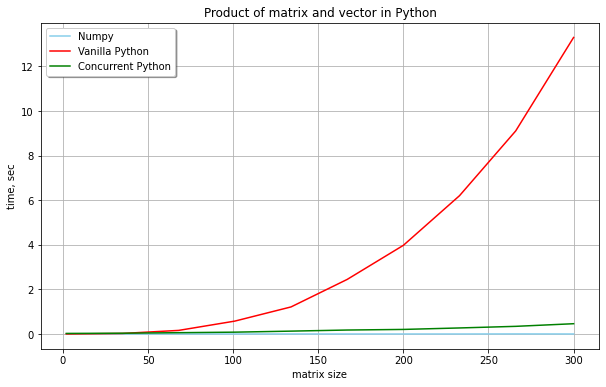

In [64]:
def plot():
  numbers = np.linspace(2, 300, 10, dtype=int)
  plot_data = [[], [], []]
  for n in numbers:
    A, b = make_matrix(n)
    M1 = Multiplication(A=A, b=b, strategy='numpy_multiplication')
    plot_data[0].append(M1.main()[1])
    M2 = Multiplication(A=A, b=b, strategy='naive_multiplication')
    plot_data[1].append(M2.main()[1])
    M3 = Multiplication(A=A, b=b, strategy='parallel_multiplication')
    plot_data[2].append(M3.main()[1])
  plt.figure(figsize=(10,6))
  plt.grid(True)
  plt.plot(numbers, plot_data[0], c='skyblue', label='Numpy')
  plt.plot(numbers, plot_data[1], c='red', label='Vanilla Python')
  plt.plot(numbers, plot_data[2], c='green', label='Concurrent Python')
  plt.xlabel('matrix size')
  plt.ylabel('time, sec')
  plt.legend(loc='upper left', shadow=True)
  plt.title('Product of matrix and vector in Python')
  plt.show()

plot()

На графике видно, что пока размерность матрицы не превышает 50, разница во времени, затрачиваемом на умножения матрицы на вектор, практически не заметна. При небольших размерностях наше наивное работает даже быстрее решения, реализованного с помощью распаралеливания умножения. Это может быть связано с тем, что при распараллеливании умножения время затрачиваемое на создание процессов может быть значительно более дорогой операцией чем само умножение. Однако на больших размерностях видим, что для наивного решения время растет экспоненциально, в то время как решение с помощью метода распараллеливания процессов показыает результаты близкие к результам вычисления встроенной функции матричного умножения библиотеки Numpy.